In [6]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.dates as mdates

# Upload the CSV
uploaded = files.upload()


Saving Retail.csv to Retail.csv


In [7]:
# Load with encoding handling
df = pd.read_csv("Retail.csv", encoding='latin1')

# Basic inspection
print("Before cleaning:", df.shape)

# Drop rows with missing essential fields
df = df.dropna(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'])

# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Quantity'] = df['Quantity'].astype(int)
df['UnitPrice'] = df['UnitPrice'].astype(float)
df['CustomerID'] = df['CustomerID'].astype(str)

# Add Revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

print("After cleaning:", df.shape)
df.head()


Before cleaning: (541909, 8)


<ipython-input-7-1640140287>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
<ipython-input-7-1640140287>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quantity'] = df['Quantity'].astype(int)
<ipython-input-7-1640140287>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

After cleaning: (406829, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [8]:
# Products Table
products = df[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)

# Customers Table
customers = df[['CustomerID', 'Country']].drop_duplicates().reset_index(drop=True)

# Transactions Table
transactions = df[['InvoiceNo', 'StockCode', 'CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate', 'Revenue']].reset_index(drop=True)


In [9]:
# Create SQLite DB
conn = sqlite3.connect("retail.db")

# Write tables
products.to_sql("products", conn, if_exists="replace", index=False)
customers.to_sql("customers", conn, if_exists="replace", index=False)
transactions.to_sql("transactions", conn, if_exists="replace", index=False)


406829

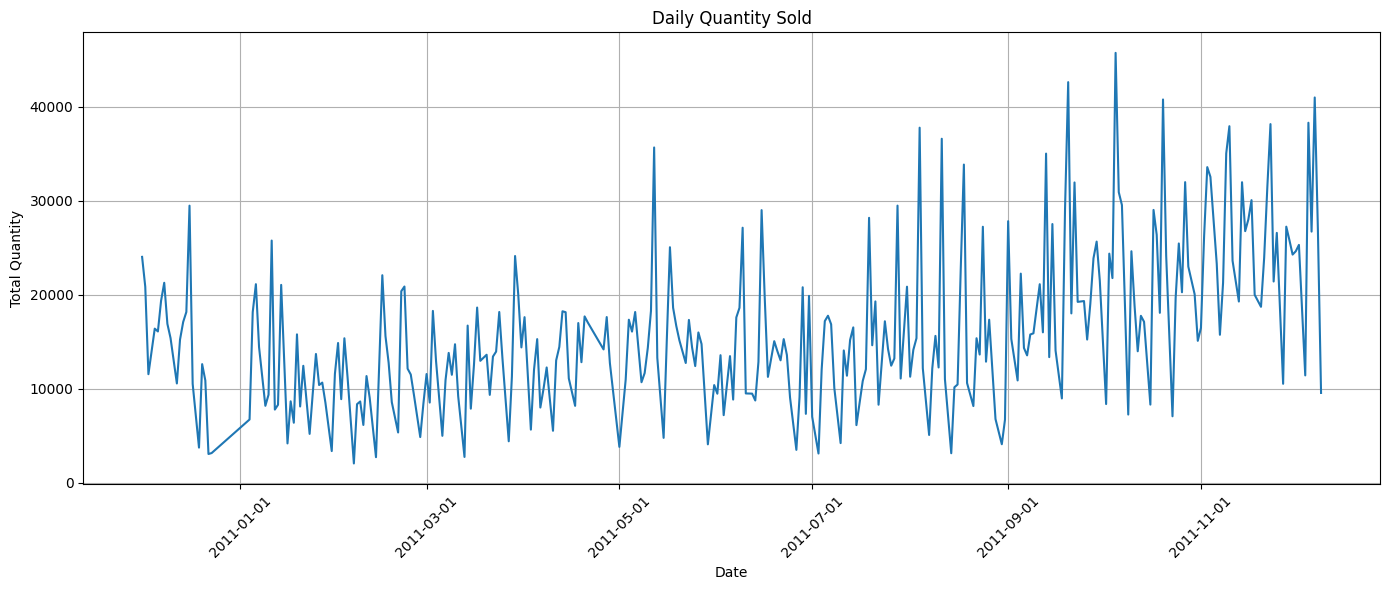

In [10]:
#Daily Quantity sold:
query = """
SELECT DATE(InvoiceDate) AS InvoiceDate, SUM(Quantity) AS TotalQuantity
FROM transactions
GROUP BY DATE(InvoiceDate)
ORDER BY DATE(InvoiceDate)
"""
daily_sales = pd.read_sql(query, conn)
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

plt.figure(figsize=(14,6))
plt.plot(daily_sales['InvoiceDate'], daily_sales['TotalQuantity'])
plt.title("Daily Quantity Sold")
plt.xlabel("Date")
plt.ylabel("Total Quantity")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


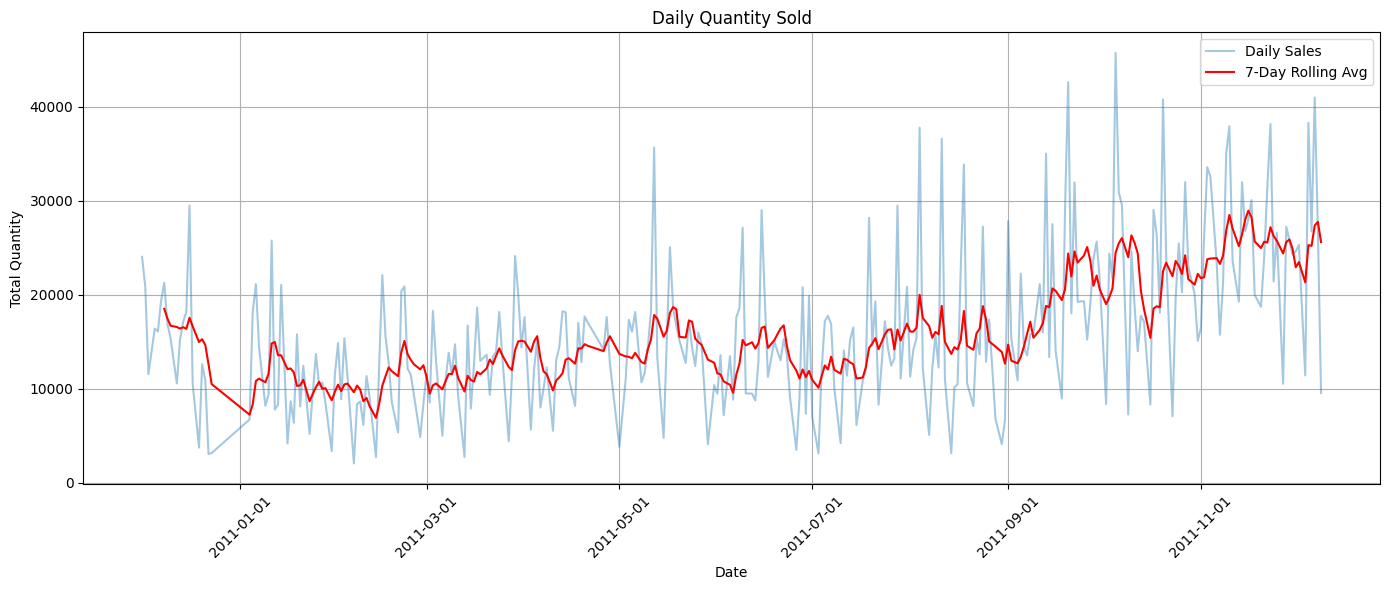

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Query remains the same
query = """
SELECT DATE(InvoiceDate) AS InvoiceDate, SUM(Quantity) AS TotalQuantity
FROM transactions
GROUP BY DATE(InvoiceDate)
ORDER BY DATE(InvoiceDate)
"""
daily_sales = pd.read_sql(query, conn)
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

# Add a 7-day rolling average to smooth the curve
daily_sales['RollingAvg'] = daily_sales['TotalQuantity'].rolling(window=7).mean()

# Plot
plt.figure(figsize=(14,6))
plt.plot(daily_sales['InvoiceDate'], daily_sales['TotalQuantity'], label='Daily Sales', alpha=0.4)
plt.plot(daily_sales['InvoiceDate'], daily_sales['RollingAvg'], color='red', label='7-Day Rolling Avg')


# Formatting
plt.title("Daily Quantity Sold")
plt.xlabel("Date")
plt.ylabel("Total Quantity")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
max_date = df['InvoiceDate'].max()
print("Max date in dataset:", max_date)

Max date in dataset: 2011-12-09 12:50:00


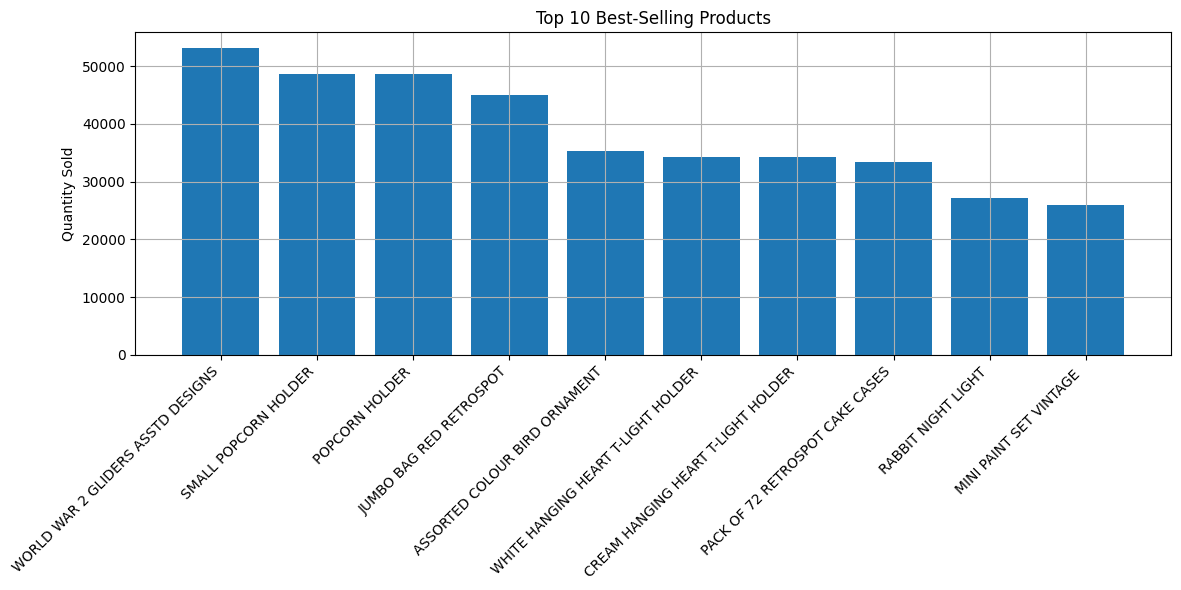

In [ ]:
#Top 10 selling notebooks
query = """
SELECT p.Description, SUM(t.Quantity) AS TotalQuantity
FROM transactions t
JOIN products p ON t.StockCode = p.StockCode
GROUP BY p.Description
ORDER BY TotalQuantity DESC
LIMIT 10
"""
top_products = pd.read_sql(query, conn)
top_products = top_products.dropna(subset=['Description'])

plt.figure(figsize=(12,6))
plt.bar(top_products['Description'], top_products['TotalQuantity'])
plt.title("Top 10 Best-Selling Products")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


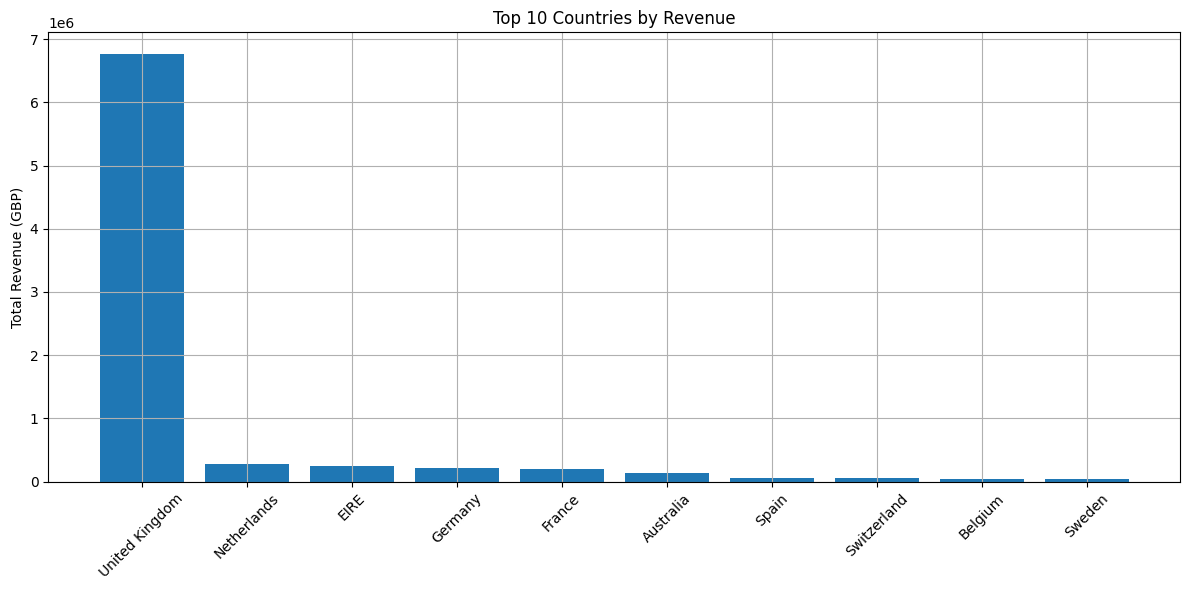

In [ ]:
#revenue by country:
query = """
SELECT c.Country, SUM(t.Revenue) AS TotalRevenue
FROM transactions t
JOIN customers c ON t.CustomerID = c.CustomerID
GROUP BY c.Country
ORDER BY TotalRevenue DESC
LIMIT 10
"""
country_sales = pd.read_sql(query, conn)

plt.figure(figsize=(12,6))
plt.bar(country_sales['Country'], country_sales['TotalRevenue'])
plt.title("Top 10 Countries by Revenue")
plt.ylabel("Total Revenue (GBP)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


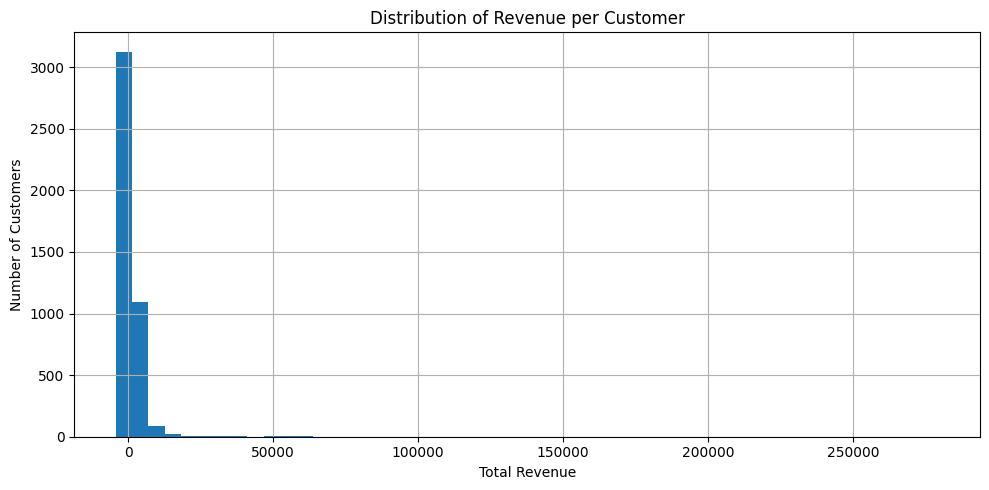

In [19]:
#revenue per customer distribution:
query = """
SELECT CustomerID, SUM(Revenue) AS TotalRevenue
FROM transactions
GROUP BY CustomerID
"""
customer_revenue = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
customer_revenue['TotalRevenue'].hist(bins=50)
plt.title("Distribution of Revenue per Customer")
plt.xlabel("Total Revenue")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
high_value_customers = customer_revenue[customer_revenue['TotalRevenue'] >= 150000]
num_high_value = len(high_value_customers)
print(f"Number of customers with total revenue ≥ 150,000: {num_high_value}")


Number of customers with total revenue ≥ 150,000: 3
